## 1. Introduction
The main objective of this showcase project is to build a predictive model to predict (i) loan status, approve/reject, for potential clients; (ii) credit score variable based on individual and loan-related attributes. <br>
The project uses the [Loan Approval Classification Dataset on Kaggle](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data?select=loan_data.csv). This report presents steps to achieve this objective. The source code of this project is available at [Github](https://github.com/ant-analytics/Beta.git).

## 2. Understand Data
Import required packages and process to load data then display the first few rows of the dataset to understand the data structure.

In [26]:
import sys
sys.path.append('./src') # ensure the src folder in the python path
import warnings
warnings.filterwarnings('ignore')
import os
import time
import datetime

import tensorflow as tf
import keras_tuner
from keras.utils import plot_model
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# project packages
from src.data_loader import load_data
from src.data_eda import *
from src.model_train import *
from src.hpmodel import *

# set project random state
random_state = 42

# Data loader
raw_data_path = './data/raw_loan_data.csv'
metadata_path = './data/metadata.txt'
raw_data, num_features, cat_features, metadata = load_data(raw_data_path, metadata_path)
metadata.sort_values(by='Type').reset_index(drop=True)

original_indices = raw_data.index # Keep the original indices for later use
raw_data.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Let's display some key information about features in the dataset:

In [2]:
metadata['na_count'] = raw_data.isna().sum().values
metadata.sort_values(by='Type').reset_index(drop=True)

,Feature,Description,Type,na_count
0,person_gender,Gender of the Person,Categorical,0
1,person_education,Highest Education Level,Categorical,0
2,person_home_ownership,Home Ownership Status,Categorical,0
3,loan_intent,Purpose of the Loan,Categorical,0
4,previous_loan_defaults_on_file,Indicator of Previous Loan Defaults,Categorical,0
5,person_age,Age of the Person,Float,0
6,person_income,Annual Income,Float,0
7,loan_amnt,Loan Amount Requested,Float,0
8,loan_int_rate,Loan Interest Rate,Float,0
9,loan_percent_income,Loan Amount as a Percentage of Annual Income,Float,0


There are 14 features in the dataset including 5 qualitative features and 9 quantitative features. The target variable is `loan_Status` which is a qualitative feature but already coded as integer; the targer 'credit_score' is quantitative feature. This finding suggests that features encoding is required for qualitative features. Additionally, there is no missing values in the dataset <br>
Let's check key information about quantitative features in the dataset:

In [3]:
describe_data(raw_data[num_features]).round(2).rename(columns=metadata.set_index('Feature')['Description'].to_dict()).T.sort_values(by='max', ascending=False)

,count,mean,std,min,25%,50%,75%,max,dtype,NaN count
Annual Income,45000.0,80319.053222,80422.498632,8000.0,47204.0,67048.0,95789.25,7200766.0,float64,0
Loan Amount Requested,45000.0,9583.157556,6314.886691,500.0,5000.0,8000.0,12237.25,35000.0,float64,0
Credit Score of the Person,45000.0,632.608756,50.435865,390.0,601.0,640.0,670.0,850.0,int64,0
Age of the Person,45000.0,27.764178,6.045108,20.0,24.0,26.0,30.0,144.0,float64,0
Years of Employment Experience,45000.0,5.410333,6.063532,0.0,1.0,4.0,8.0,125.0,int64,0
Length of Credit History in Years,45000.0,5.867489,3.879702,2.0,3.0,4.0,8.0,30.0,float64,0
Loan Interest Rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.0,float64,0
loan_status,45000.0,0.222222,0.415744,0.0,0.0,0.0,0.0,1.0,int64,0
Loan Amount as a Percentage of Annual Income,45000.0,0.139725,0.087212,0.0,0.07,0.12,0.19,0.66,float64,0


As can be seen from statistic summary, the range of values for each feature is different. For example the range of income is from 80K to 7000K while the range of age is from 20 to 144. This finding sugests that the features need to be rescaled before serving as input to the model. <br>
Addtionally, there are unusual values in the dataset such as the age of a person is 144 or year of employment experiece is 125. These values are not practical and need to be treated as outliers. <br>.
Let's display a dashboard to have an over view of the dataset:

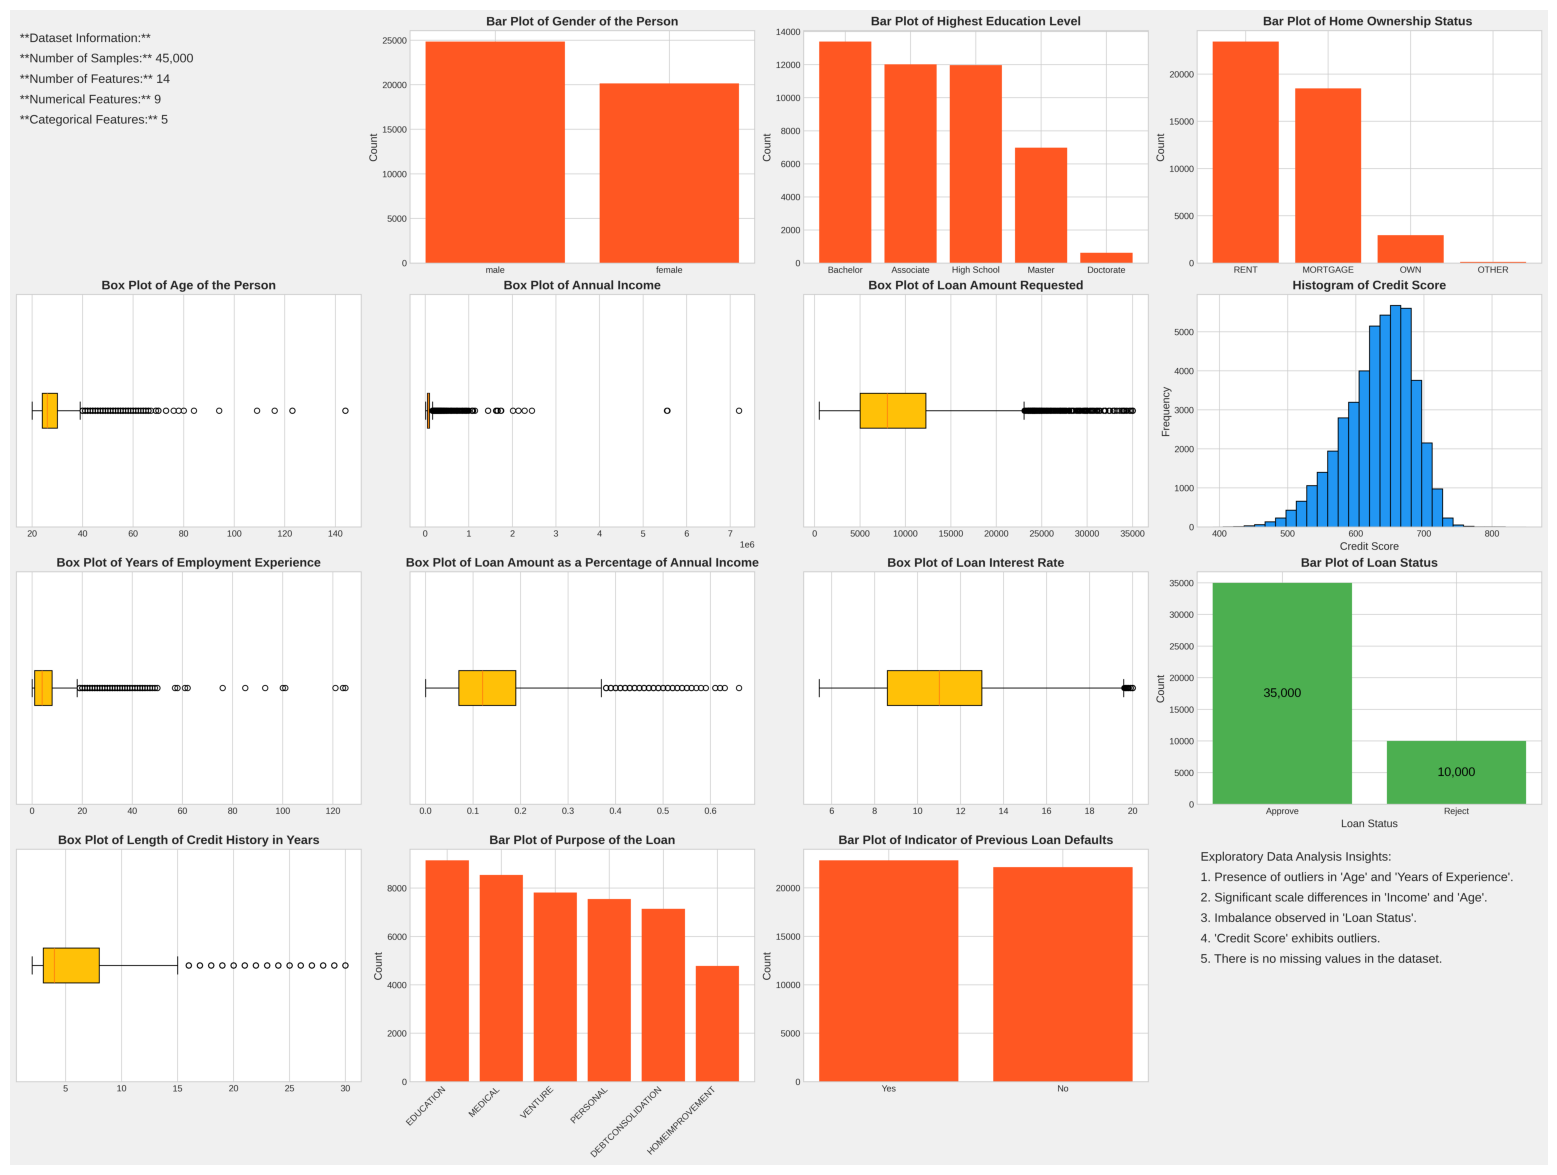

In [31]:
import matplotlib.image as mpimg
img = mpimg.imread('plots/eda_dashboard.png')

# display image
fig, ax = plt.subplots(figsize=(30, 15))  # make the image wider
ax.imshow(img)
ax.axis('off')  # hide axis

plt.show()


From the dashboard, we can see that number of reject and approve loand are imbalanced. Therefore, we should use stratified sampling methods to ensure that train, validation and test set maintain this propotion. <br>


## 3. Data Preparation
In this project, I will divide the dataset to train, validation and test set with propotion of 50-30-20, respectively. The source code for split function is available at [Github](https://github.com/ant-analytics/Beta.git).


In [5]:
# Data split
from src.data_preprocessing import split_data, preprocess_data, transform_features
X_train, X_val, X_test, y_train_loan_status, y_val_loan_status, y_test_loan_status, y_train_score, y_val_score, y_test_score = split_data(raw_data)
print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (21600, 12)
Validation data shape: (14400, 12)
Test data shape: (9000, 12)


As mentioned above, outliers with respect to person age and  are presented in the dataset. These data points should be labeled and remove from the set properly. In this project, I use Isolation Forest method to detect ouliers. Details about isolation forest can be found at [Wikipedia](https://en.wikipedia.org/wiki/Isolation_forest). To do that, I will train a outliers detector on train set, use person age, year of employment experience and length of credit history in years as features to train. 

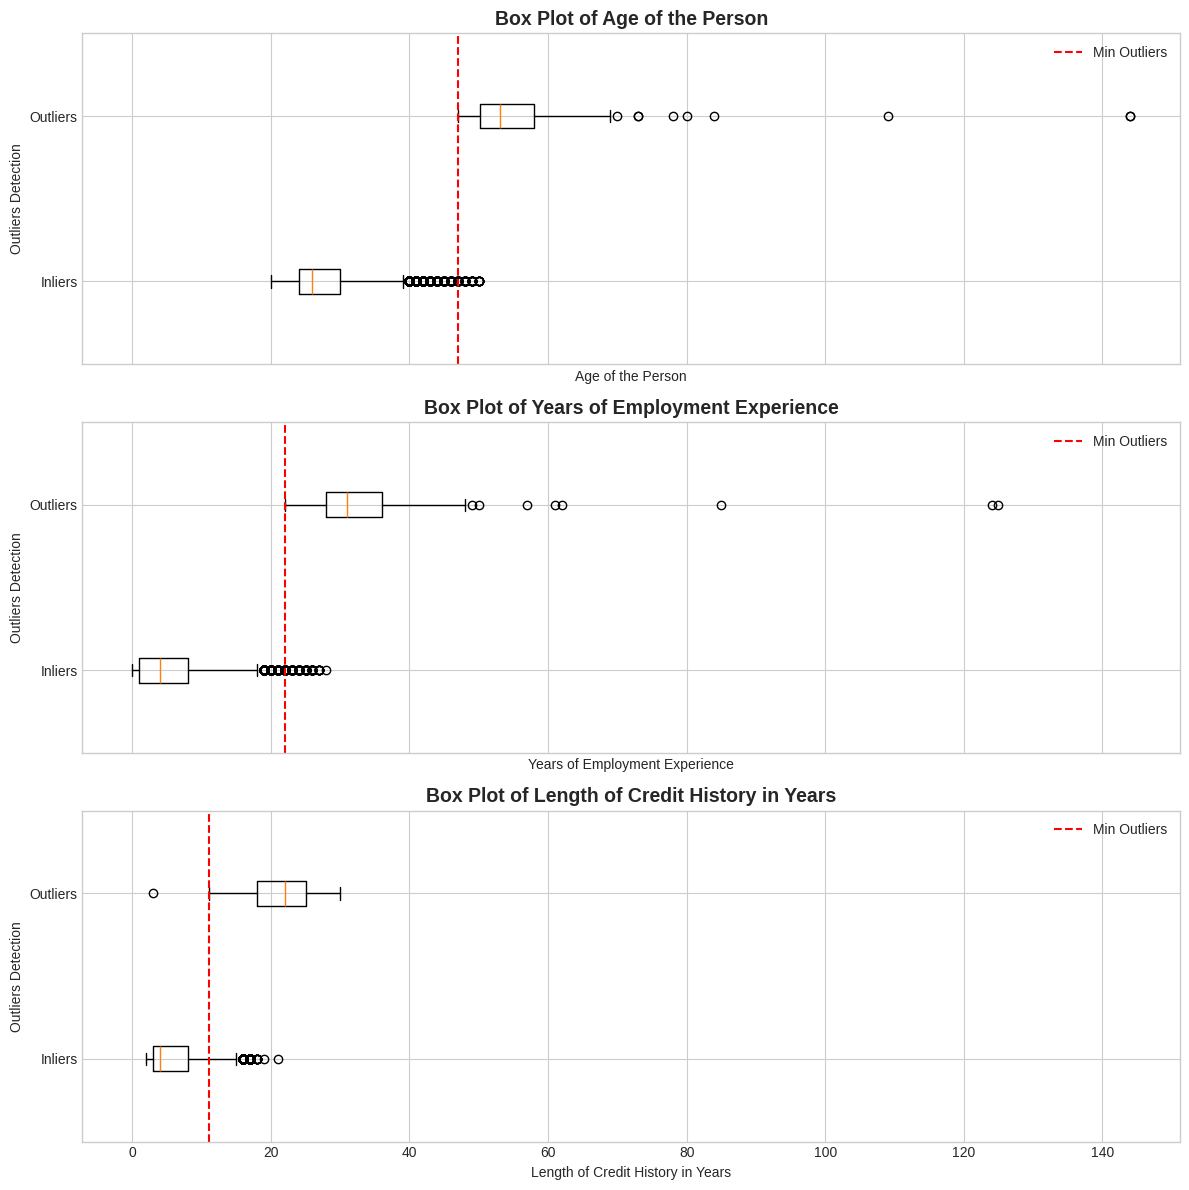

In [6]:
# outlier detection
from sklearn.ensemble import IsolationForest
outlier_features = ['person_age', 'person_emp_exp', 'cb_person_cred_hist_length']
outlier_detector = IsolationForest(contamination=0.009, random_state=random_state)
X_train['outliers'] = outlier_detector.fit_predict(X_train[outlier_features])
indices_to_remove = X_train[X_train['outliers'] == -1].index # Get the indices of the outliers

# Plot box plot
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
for i, feature in enumerate(X_train[['person_age', 'person_emp_exp', 'cb_person_cred_hist_length']].columns):
    description = metadata.loc[metadata['Feature'] == feature, 'Description'].values[0]
    ax = axs[i]
    boxplot = ax.boxplot([X_train[X_train['outliers'] == 1][feature], X_train[X_train['outliers'] == -1][feature]], 
                         labels=['Inliers', 'Outliers'], vert=False)
    ax.set_title(f'Box Plot of {description}', fontweight='bold', fontsize=14)
    ax.set_xlabel(description)
    ax.set_ylabel(f'Outliers Detection')
    
    # # Add mean annotation for inliers
    # mean_inliers = boxplot['means'][0].get_xdata()[0]
    # ax.annotate(f'Mean: {mean_inliers:.2f}', xy=(mean_inliers, 1), xytext=(mean_inliers + 0.5, 1.1),
    #             horizontalalignment='center', verticalalignment='center')
    
    # # Add mean annotation for outliers
    # mean_outliers = boxplot['means'][1].get_xdata()[0]
    # ax.annotate(f'Mean: {mean_outliers:.2f}', xy=(mean_outliers, 2), xytext=(mean_outliers + 1, 2.1),
    #             horizontalalignment='center', verticalalignment='center')
    
    # Draw vertical line through min values
    # min_inliers = boxplot['whiskers'][0].get_xdata()[0]
    min_outliers = boxplot['caps'][2].get_xdata()[0]
    # ax.axvline(min_inliers, color='r', linestyle='--', label='Min Inliers')
    ax.axvline(min_outliers, color='r', linestyle='--', label='Min Outliers')
    
    # Add tick label for red line
    # ax.annotate(f'{min_inliers:.2f}', xy=(min_inliers, 0.5), xytext=(min_inliers, 0.5),
    #             color='red', horizontalalignment='center', verticalalignment='center')
    # ax.annotate(f'{min_outliers:.2f}', xy=(min_outliers, 1.5), xytext=(min_outliers, 1.5),
    #             color='red', horizontalalignment='center', verticalalignment='center')
    
    ax.legend()

fig.tight_layout()
plt.show()


As we can see from the plot, the outlier dectector are reasonable to detect outlier in the dataset. We will use this detector to remove outliers from the validation and test set.

In [7]:
# Remove outliers
X_train.drop(index=indices_to_remove, columns='outliers', inplace=True)
y_train_loan_status.drop(labels=indices_to_remove, inplace=True)
y_train_score.drop(labels=indices_to_remove, inplace=True)

# Remove outliers from validation set
X_val['outliers'] = outlier_detector.predict(X_val[outlier_features])
val_indices_to_remove = X_val[X_val['outliers'] == -1].index
X_val.drop(index=val_indices_to_remove, columns='outliers', inplace=True)
y_val_loan_status.drop(labels=val_indices_to_remove, inplace=True)
y_val_score.drop(labels=val_indices_to_remove, inplace=True)

# Remove outliers from test set
X_test['outliers'] = outlier_detector.predict(X_test[outlier_features])
test_indices_to_remove = X_test[X_test['outliers'] == -1].index
X_test.drop(index=test_indices_to_remove, columns='outliers', inplace=True)
y_test_loan_status.drop(labels=test_indices_to_remove, inplace=True)
y_test_score.drop(labels=test_indices_to_remove, inplace=True)

The next step is to preprocess data. Two tasks need to be done: (i) encode categorical variables and (ii) scale numerical variables. For the first task, I will use ordinal endcode method to encode categorical variables. For the second task, I will use standard scaler to scale numerical variables. The source code for these tasks is available at [Github](https://github.com/ant-analytics/Beta.git).

In [8]:
# Data preprocessing
X_train_transform, X_val_transform, X_test_transform, y_train_score_transform, y_val_score_transform, y_test_score_transform, col_transformer, y_scaler = preprocess_data(
    X_train, X_val, X_test, y_train_score, y_val_score, y_test_score, num_features, cat_features)

# keep track features for interpretate
transform_features = transform_features(col_transformer)

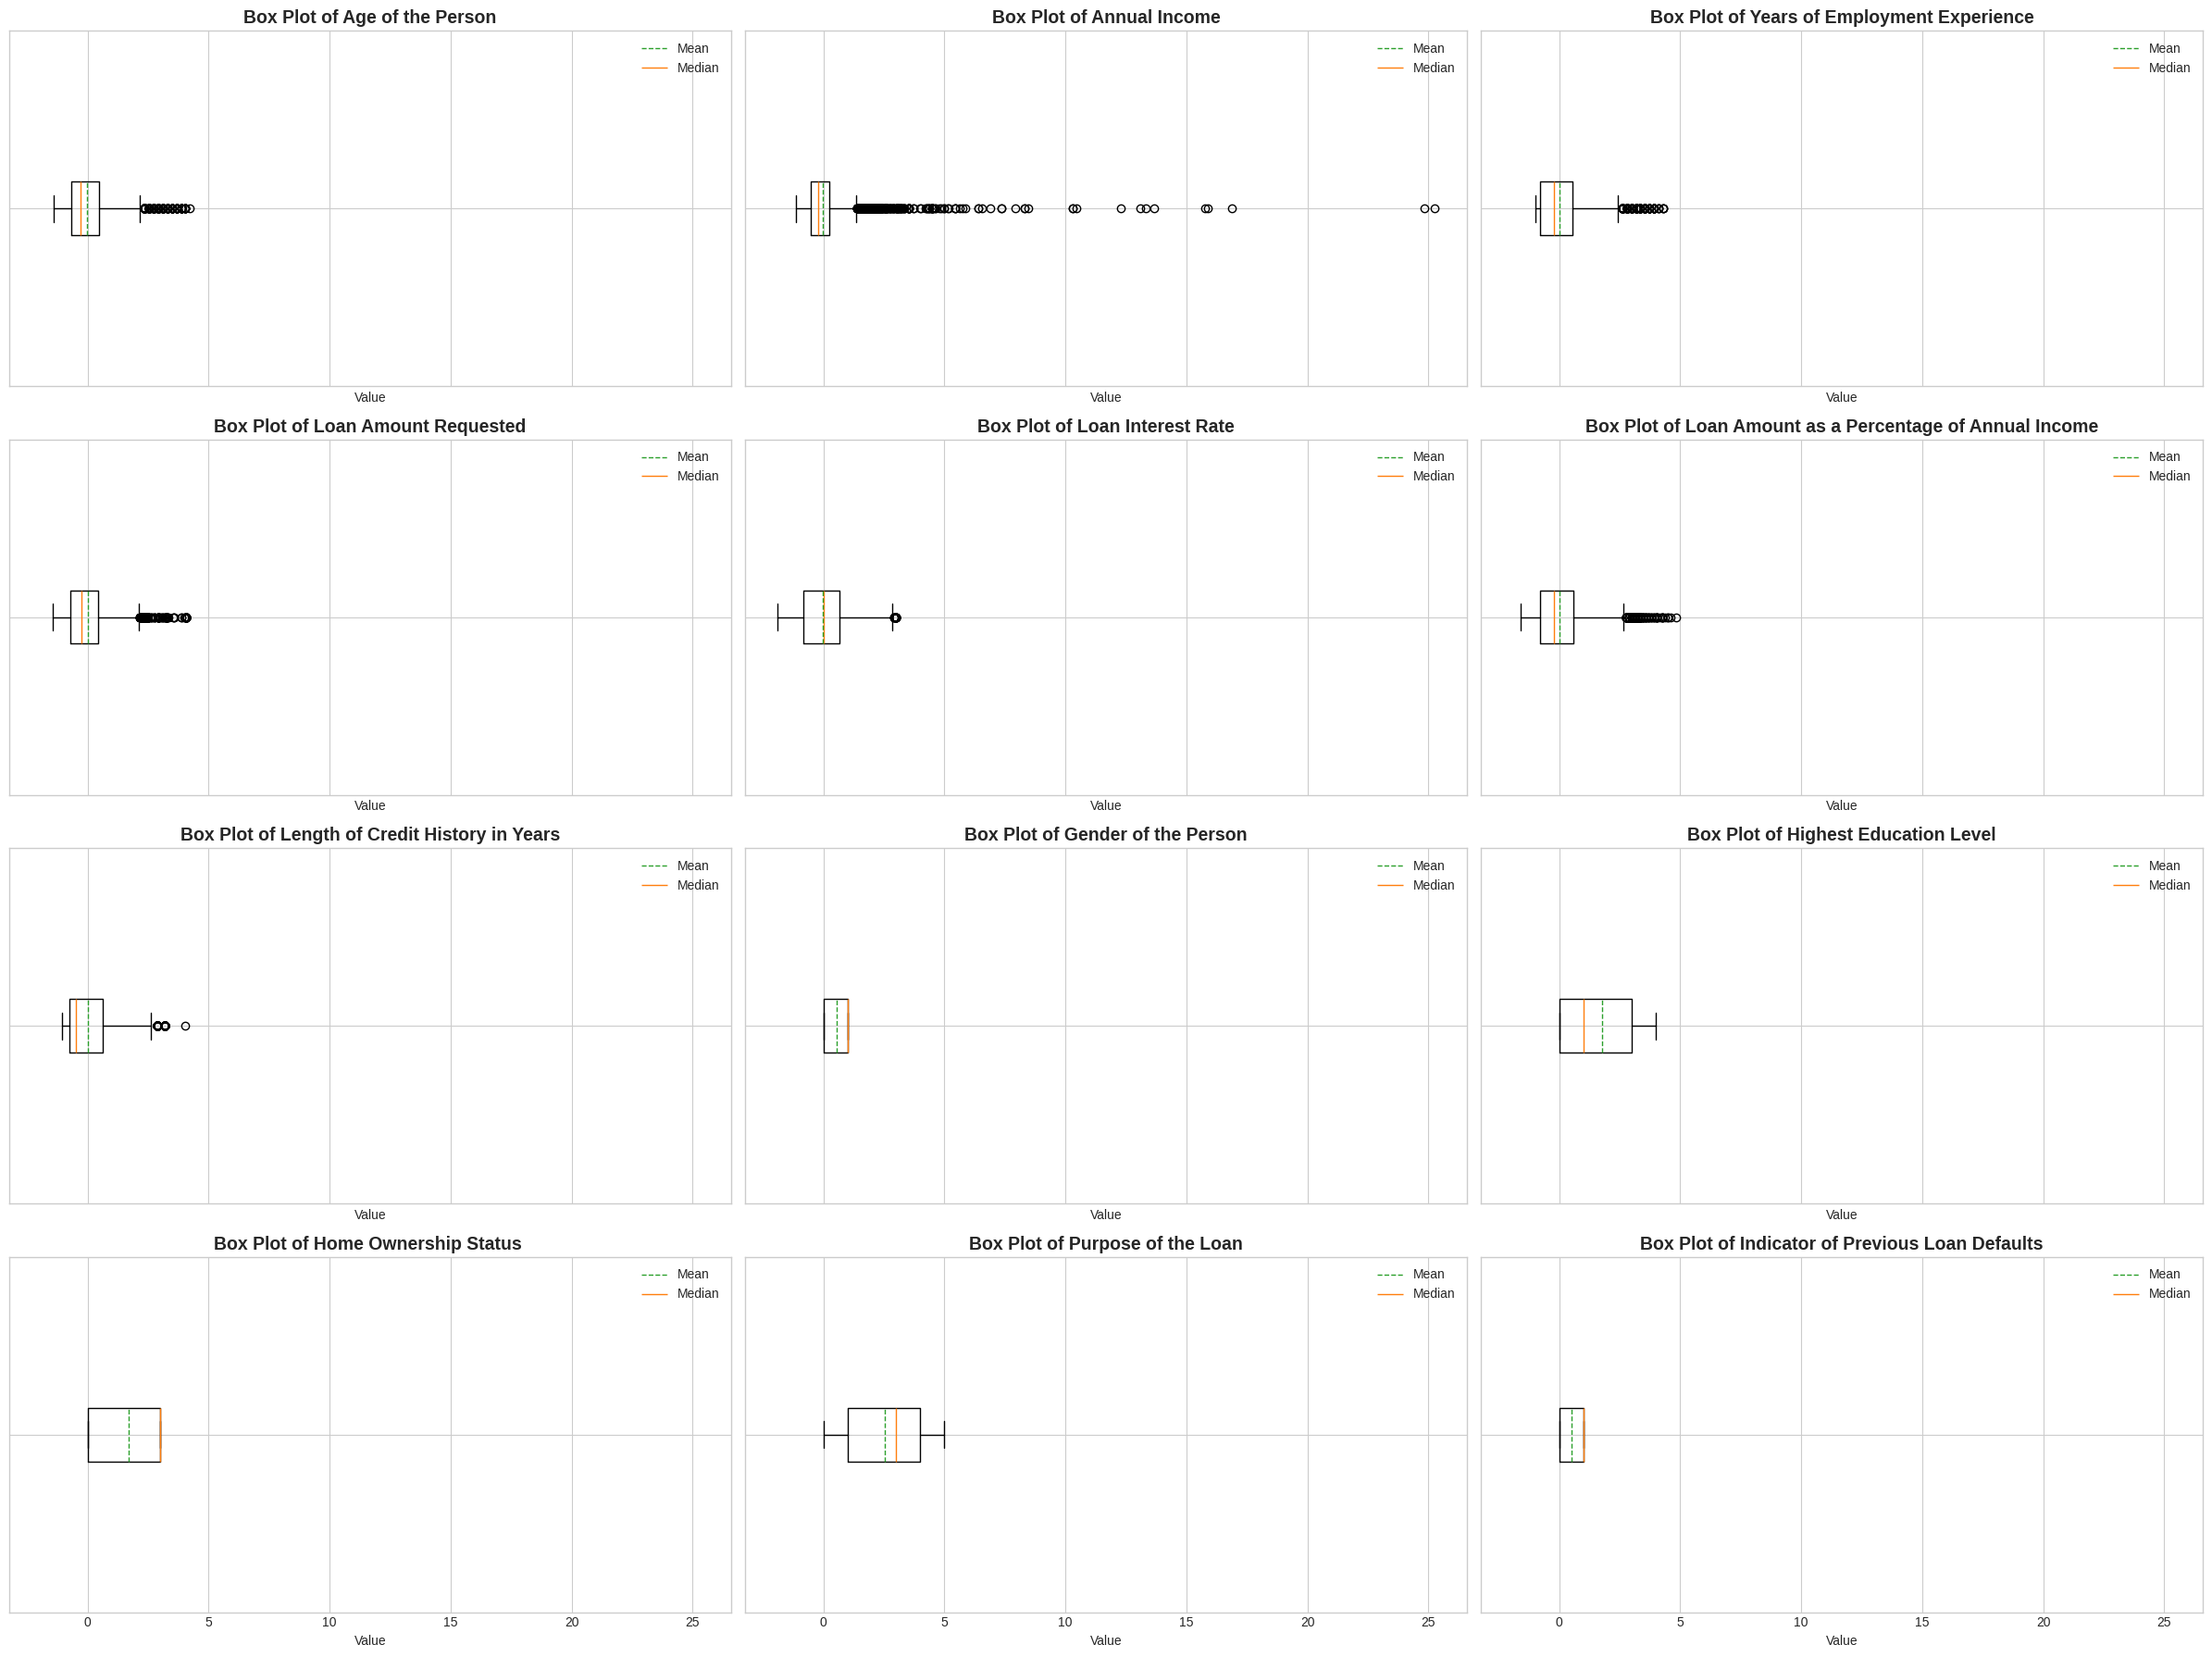

In [9]:
#  plot features after transform
fig, axs = plt.subplots(4, 3, figsize=(24, 18), sharex=True)
for i, feature in enumerate(transform_features):
    ax = axs[i//3, i%3]
    boxplot = ax.boxplot(X_test_transform[:, i], showfliers=True, vert=False, showmeans=True, meanline=True)
    description = metadata.loc[metadata['Feature'] == feature, 'Description'].values[0]
    ax.set_title(f'Box Plot of {description}', fontweight='bold', fontsize=14)
    ax.yaxis.set_ticklabels([])  # Set y-tick labels off
    
    # Add mean annotation
    # mean = boxplot['means'][0].get_xdata()[0]
    # ax.annotate(f'Mean: {mean:.2f}', xy=(mean, 1), xytext=(mean, 1.1),
    #             arrowprops=dict(facecolor='black', shrink=0.05),
    #             horizontalalignment='center', verticalalignment='center')
    
    # Add x-axis label
    ax.set_xlabel('Value')
    
    # Add legend for mean and median lines
    ax.legend([boxplot['means'][0], boxplot['medians'][0]], ['Mean', 'Median'], loc='upper right')

fig.tight_layout()
plt.show()

## 4. Model Development and Training
The purpose of this project is to predict loan status and credit score. These outputs are different in nature. Loan status is a binary output coded as 1 for approve and 0 for reject. Meanwhile, credit score is a continuous variable. Thus, our problems are classification and regression problems. The predictive models use the same set of input data. A popular choice for this type of problem is to develop two separate models for each problem. However, in this project, I will use a single neural network model to predict both loan status and credit score.<br>
The next step is to build the model architecture, set up hyperparameters, and train the network. A common approach to developing the network is to start with a reasonable architecture and hyperparameters, then tune them to improve the model performance. But, in this project, I will do it in reverse order. I will start with tuning hyperparameters, then choose the "best" model architecture. From this point, I will train the model and evaluate its performance.

In [12]:
# Hyperparameter tuning
tuner_log_dir = f"logs/tuner/tuner_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tuner_save_check_point = f'save_tuner/checkpoint_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.keras'

# Create TensorBoard callback
tuner_tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=tuner_log_dir,  
    histogram_freq=1,
    profile_batch='500,520'
)

tuner_early_stop_callback = keras.callbacks.EarlyStopping(
    monitor='val_output_status_accuracy',
    patience=3,
    mode='max'
)

tuner_check_point = keras.callbacks.ModelCheckpoint(
    filepath=f'best_tuner_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.keras',
    monitor='val_output_status_accuracy',
    save_best_only=True,
)

tuner_callbacks = [tuner_tensorboard_callback, tuner_early_stop_callback, tuner_check_point]
 
tuner = keras_tuner.GridSearch(
    hypermodel=build_hyper_model,
    objective=[
        keras_tuner.Objective('val_output_status_accuracy', direction='max'),
        keras_tuner.Objective('val_output_score_mean_squared_error', direction='min')
    ],
    max_trials=50,
    directory=tuner_log_dir,
    project_name='loan_default_prediction',
    overwrite=True
)
# Tuning hyperparameters
tuner.search(
    X_train_transform, y=[y_train_loan_status, y_train_score_transform],
    validation_data=(X_val_transform, [y_val_loan_status, y_val_score_transform]), epochs=50,
    callbacks=tuner_callbacks
)


Trial 50 Complete [00h 02m 02s]
multi_objective: 0.07645416259765625

Best multi_objective So Far: 0.028863966464996338
Total elapsed time: 01h 43m 02s


In [15]:

# Retrieve and save the top 10 best models
save_dir = 'save_tuner/top_best/'
os.makedirs(save_dir, exist_ok=True)
best_models = tuner.get_best_models(num_models=10)
for i, model in enumerate(best_models):
    model.save(f'save_tuner/top_best/{i+1}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.keras')

save_worst = 'save_tuner/top_worst/'
os.makedirs(save_worst, exist_ok=True)
worst_models = tuner.get_best_models(num_models=50)[-10:]
for i, model in enumerate(worst_models):
    model.save(f'save_tuner/top_worst/{i+1}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.keras')

After tuning, choose the best model then plot model architecture.

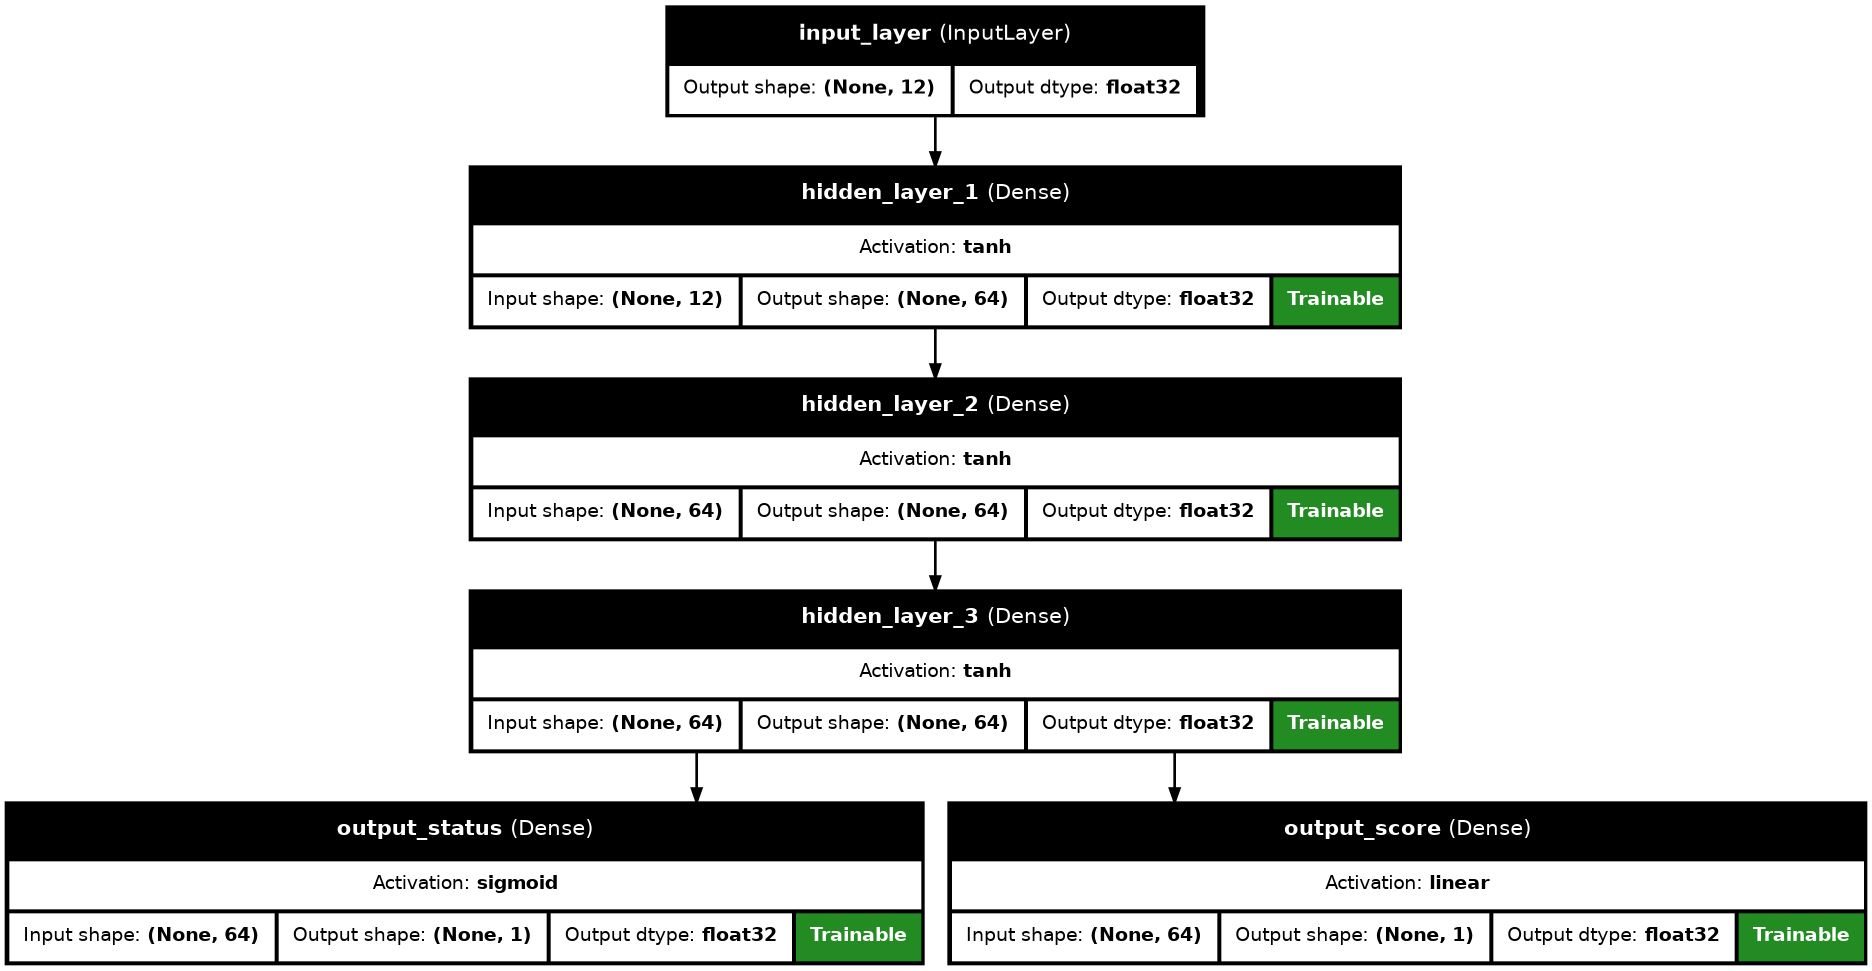

In [16]:
# load the best model
best_model = tuner.get_best_models(num_models=1)[0]
plot_model(best_model, to_file=f'plots/best_model_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True, show_dtype=True, dpi=96)


Now, it is time to train the model. The training process will take a while. After training, we will evaluate the model performance on the validation set. The evaluation metrics for classification and regression problems are accuracy and mean squared error, respectively.

In [ ]:
#  calbacks for fit model
fit_log_dir = f"logs/fits/fit_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
fit_save_check_point = f'save_fits/checkpoint_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.keras'

# Create TensorBoard callback
fit_tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=fit_log_dir,  
    histogram_freq=1,
    profile_batch='500,520'
)

fit_early_stop_callback = keras.callbacks.EarlyStopping(
    monitor='val_output_status_accuracy',
    patience=3,
    mode='max'
)

fit_check_point = keras.callbacks.ModelCheckpoint(
    filepath=fit_save_check_point,
    monitor='val_output_status_accuracy',
    save_best_only=True,
)

fit_callbacks = [fit_tensorboard_callback, fit_early_stop_callback, fit_check_point]

#  fit the best model
history = best_model.fit(
    X_train_transform, [y_train_loan_status, y_train_score_transform],
    validation_data=(X_val_transform, [y_val_loan_status, y_val_score_transform]),
    epochs=100, callbacks=fit_callbacks, shuffle=True
)

# model evaluation
evaluation = best_model.evaluate(X_test_transform, [y_test_loan_status, y_test_score_transform], return_dict=True)

In [25]:
import pandas as pd

# Convert the evaluation dictionary to a DataFrame
evaluation_df = pd.DataFrame(list(evaluation.items()), columns=['Metric', 'Value']).round(2)

# Display the DataFrame
print(evaluation_df)

                            Metric  Value
0                             loss   1.15
1                output_score_loss   0.95
2  output_score_mean_squared_error   0.95
3           output_status_accuracy   0.91
4               output_status_loss   0.20
5          output_status_precision   0.82
6             output_status_recall   0.76


  1/279 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


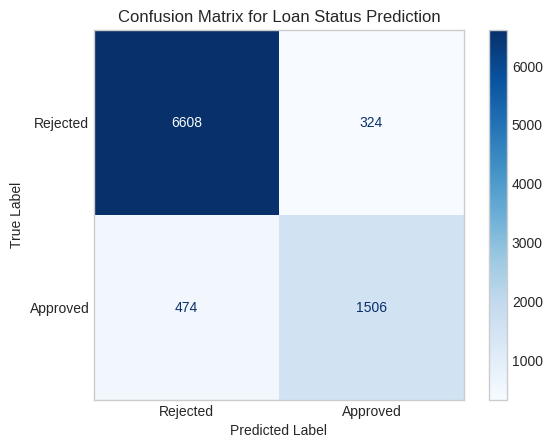

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict loan status on the test set
y_pred_loan_status = best_model.predict(X_test_transform)[0]
y_pred_loan_status = (y_pred_loan_status > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_loan_status, y_pred_loan_status)

# Plot confusion matrix without grid
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Rejected', 'Approved'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Loan Status Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['Rejected', 'Approved'])
plt.yticks(ticks=[0, 1], labels=['Rejected', 'Approved'])
plt.grid(False)  # Remove grid
plt.show()

## 5. Conclusion and Discussion 

This project has built a a predictive model to predict loan status and credit score base of 45K sample dataset. The model use IsolationForest to detect outliers and use a single neural network model to predict both loan status and credit score. However, this project stil need improvement in the following aspects: (i) a multi criteria should be use to monitor hypertuning process; (ii) should develop a different models to comparison./. <br>